# Trend Model

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter

# Path Management

In [2]:
path = r"A:\2025Backup\BBGFuturesManager_backup\data\PXFront"
spx_path  = os.path.join(path, "ES.parquet")

In [3]:
sys.path.append(r"C:\Users\Diego\Documents\GitHub\TrendConvexity\src")
from collectData import DataCollector

# Make Signature Plot

In [4]:
def prep_data(path: str) -> pd.DataFrame:

    df_out = (pd.read_parquet(
        path = path, engine = "pyarrow").
        assign(date = lambda x: pd.to_datetime(x.date)).
        drop(columns = ["security"]).
        rename(columns = {"PX_LAST": "price"}).
        set_index("date"))
    
    return df_out

df_spx = prep_data(spx_path)

In [5]:
def get_all_data() -> pd.DataFrame:
    
    full_path = r"A:\2025Backup\BBGFuturesManager_backup\data\PXFront"
    paths = [os.path.join(full_path, path) for path in os.listdir(full_path) if path != "NG.parquet" and path != "UX.parquet"]
    dfs = pd.concat([prep_data(path).assign(security = path.split("\\")[-1].split(".")[0]) for path in paths])
    
    return dfs

df_all = get_all_data()

In [6]:
def get_signature_plot(df: pd.DataFrame) -> pd.DataFrame: 
    
    rtns = df.pct_change().price.dropna()
    timesteps = [int(i + 1) for i in range(200)]
    stds = [
        (rtns.rolling(window = timestep).std().mean()) / rtns.std()
        for timestep in timesteps]

    df_signature = (pd.DataFrame({
        "timestep": timesteps,
        "stds": stds}).
        dropna().
        set_index("timestep"))
    
    return df_signature

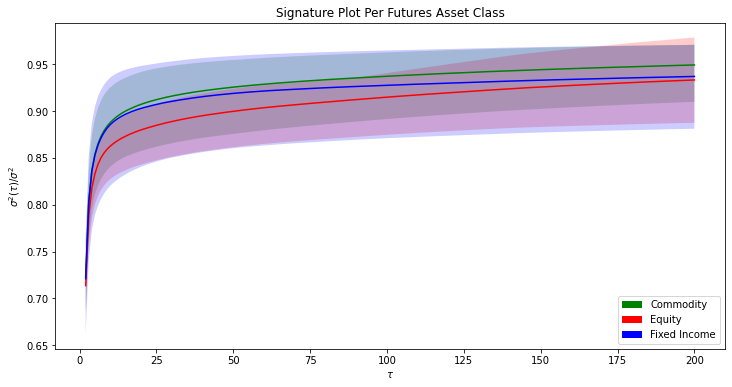

In [7]:
def make_singature_plot(df_all: pd.DataFrame) -> plt.Figure: 

    df_signature_plot = (df_all.groupby(
        "security").
        apply(get_signature_plot).
        reset_index())

    path        = r"A:\2025Backup\BBGFuturesManager_backup\root\fut_tickers.xlsx"
    bad_tickers = ["SFR", "SER", "FF"] 
    
    df_kind = (pd.read_excel(
        io = path, sheet_name = "px")
        [["contract", "kind"]].
        rename(columns = {"contract": "security"}).
        query("security != @bad_tickers"))

    df_combined = (df_signature_plot.merge(
        right = df_kind, how = "inner",on = ["security"]))

    colors = {
        "Commodity": "Green",
        "Equity": "Red",
        "Fixed Income": "Blue"}

    legend_elements = [Patch(facecolor = colors[security_kind], label = security_kind) for security_kind in colors.keys()]
    fig, axes = plt.subplots(figsize = (12,6))
    for contract_kind in colors.keys():

        df_plot = (df_combined.query(
            "kind == @contract_kind").
            drop(columns = ["kind"]).
            pivot(index = "timestep", columns = "security", values = "stds"))

        df_minmax = (df_plot.reset_index().melt(
            id_vars = "timestep").
            drop(columns = ["security"]).
            groupby("timestep").
            agg(["min", "max"])
            ["value"])

        axes.fill_between(
            x = df_minmax.index,
            y1 = df_minmax["min"],
            y2 = df_minmax["max"],
            alpha = 0.2,
            facecolor = colors[contract_kind])

        df_plot.mean(axis = 1).plot(color = colors[contract_kind])

        axes.legend(handles = legend_elements, loc = "lower right")
        axes.set_xlabel(r"$\tau$")
        axes.set_ylabel(r"$\sigma^2(\tau)/\sigma^2$")
        axes.set_title("Signature Plot Per Futures Asset Class")
        
make_singature_plot(df_all)

# Prepping Time Series

We are going to normalize the returns of the strategy to make strategies unit variance. They use a method to get the EWMA of daily volatility. <br>
$$
\begin{equation}
\sigma_t := \gamma \sqrt{\mathcal{L}_{\tau_{\sigma}}[D_t^2]}
\end{equation}
$$
Then apply that to the Returns $R_t$
$$
\begin{equation}
R_t = \frac{D_t}{\sigma_{t-1}}
\end{equation}
$$
They authors set these parameters as $\gamma = 1.05$ and $\tau_{\sigma} = 10$.

# Simple Trend Model

The authors begin with the following relationship between the performance of the trend and the variance of the returns.

$$
\begin{aligned}
\mathcal{G}_T &= \sum_{t = 1}^T G_t\\
            &=\frac{\lambda}{2} \left( \left( \sum_{t=1}^T R_t \right)^2 - \sum_{t=1}^T R_t^2 \right)\\
\end{aligned}
$$

They use a trend following signal on prior returns $\mathcal{L}_{\tau}(R_t)$. An analog relationship follows <br>
\begin{equation}
\mathcal{L}_{\tau'}[G_t] = \frac{\lambda \tau}{\tau - 1} \left( \tau \mathcal{L}_{\tau}^2[R_t] - \mathcal{L}_{\tau'}[R_t^2]\right) 
\end{equation}
Where $\tau'$ follows <br>
\begin{align}
\tau' &= \frac{\tau}{2} + \frac{1}{2\tau}\\
&\thickapprox \frac{\tau}{2}
\end{align}

Let's make a simple trend following model with $\tau$ = 180 and $\tau'$ = 90

In [8]:
def get_data() -> pd.DataFrame: 
    
    df_out = (pd.concat([
        DataCollector().collect_futures().rename(columns = {"PX_LAST": "value"}), 
        DataCollector().collect_fx()]))
    
    return df_out

df = get_data()

In [9]:
def get_two_window_trend(df: pd.DataFrame, window: int = 180) -> pd.DataFrame: 

    df_signal = (df.pivot(
        index = "date", columns = "security", values = "value").
        diff().
        apply(lambda x: x / (x.ewm(span = 10, adjust = False).std())).
        apply(lambda x: x.ewm(span = window / 2, adjust = False).mean() - x.ewm(span = window, adjust = False).mean()))

    df_rtn = (df.pivot(
        index = "date", columns = "security", values = "value").
        pct_change())

    df_tf_raw_rtn = (
        (np.sign(df_signal.shift()) * df_rtn))

    df_scaled_tf_rtn = (df_tf_raw_rtn.apply(
        lambda x: x * (0.20 / (x.ewm(span = 250, adjust = False).std().shift() * np.sqrt(252)))))
    
    return df_signal, df_tf_raw_rtn, df_scaled_tf_rtn

two_window = get_two_window_trend(df)

In [10]:
def get_one_window_trend(df: pd.DataFrame, window: int = 180) -> pd.DataFrame: 

    df_signal = (df.pivot(
        index = "date", columns = "security", values = "value").
        diff().
        apply(lambda x: x / (x.ewm(span = 10, adjust = False).std())).
        apply(lambda x: x.ewm(span = window, adjust = False).mean()))

    df_rtn = (df.pivot(
        index = "date", columns = "security", values = "value").
        pct_change())

    df_tf_raw_rtn = (
        (np.sign(df_signal.shift()) * df_rtn))

    df_scaled_tf_rtn = (df_tf_raw_rtn.apply(
        lambda x: x * (0.20 / (x.ewm(span = 250, adjust = False).std().shift() * np.sqrt(252)))))
    
    return df_signal, df_tf_raw_rtn, df_scaled_tf_rtn

one_window = get_one_window_trend(df)

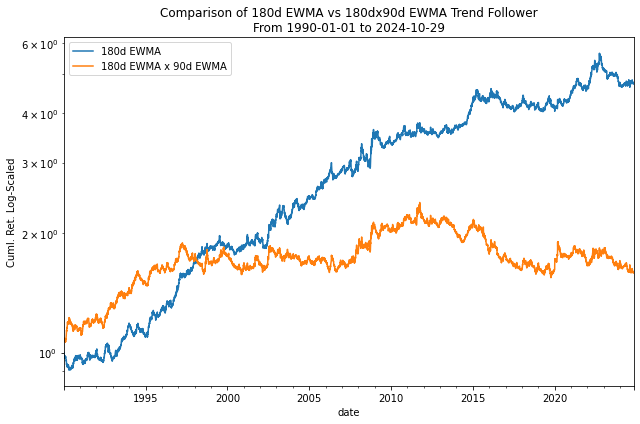

In [11]:
df_one_window = one_window[2].mean(axis = 1).to_frame(name = "one_window")
df_two_window = two_window[2].mean(axis = 1).to_frame(name = "two_window")

(df_one_window.merge(
    right = df_two_window, how = "inner", on = ["date"]).
    dropna().
    apply(lambda x: np.cumprod(1 + x)).
    rename(columns = {
        "one_window": "180d EWMA",
        "two_window": "180d EWMA x 90d EWMA"}).
    plot(
        logy = True,
        ylabel = "Cuml. Ret. Log-Scaled",
        figsize = (9,6),
        title   = "Comparison of 180d EWMA vs 180dx90d EWMA Trend Follower\nFrom {} to {}".format(
            df_one_window.index.min().date(),
            df_two_window.index.max().date())))

plt.tight_layout()

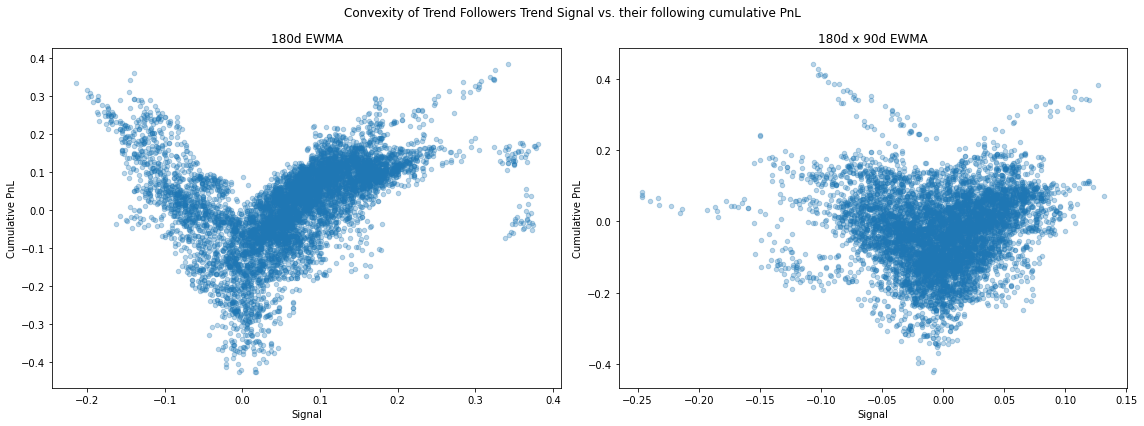

In [12]:
tuple_group = {"one_window": one_window, "two_window": two_window}
renamer     = {"one_window": "180d EWMA", "two_window": "180d x 90d EWMA"}
fig, axes   = plt.subplots(ncols = 2, figsize = (16,6))

for tuple_, ax in zip(tuple_group.keys(), axes.flatten()):
    
    df_signal = (tuple_group[tuple_][0][
        ["ES1 Index"]].
        rename(columns = {"ES1 Index": "signal"}))
    
    df_trend = (tuple_group[tuple_][2][
        ["ES1 Index"]].
        rename(columns = {"ES1 Index": "trend_rtn"}))
    
    (df_signal.merge(
        right = df_trend, how = "inner", on = ["date"]).
        dropna().
        assign(cuml_pnl = lambda x: x.trend_rtn.rolling(window = 90).sum()).
        plot(
            ax     = ax,
            kind   = "scatter", 
            x      = "signal", 
            y      = "cuml_pnl",
            alpha  = 0.3,
            xlabel = "Signal",
            ylabel = "Cumulative PnL",
            title  = renamer[tuple_]))

fig.suptitle("Convexity of Trend Followers Trend Signal vs. their following cumulative PnL")
plt.tight_layout()